<a href="https://colab.research.google.com/github/jbaquerot/Master-Data-Science-UV-2019/blob/master/Fairer_ML_AdversarialTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# imports
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight


import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


print("pythoch version: {}".format(torch.__version__))

device = "cpu"

pythoch version: 1.2.0


# FAIRER MACHINE LEARNING: IS IT POSSIBLE?

## ML FOR DECISION MAKING
From credit ratings to online dating, machine learning models are increasingly used to automate 'everyday' decision making processes. 

## GROWING IMPACT ON SOCIETY
More and more concerns are being voiced about the loss of transparency, accountability and fairness of the algorithms making the decisions.

## MACHINE LEARNING & DISCRIMINATION

We need to step-up and look for ways to mitigate emergent discrimination in our models. Make sure that our predictions do not hurt people unfairly with certain sensitive characteristics (e.g., gender, ethnicity, etc.).

# Making income predictions

Let's start by training a basic classifier that can predict whether or not a person's income is larger than 50K dollar a year. We'll be working with some California Census Data, we'll be trying to use various features of an individual to predict what class of income they belogn in (>50k or <=50k). It is not hard to imagine that financial institutions train models on similar data sets and use them to decide whether or not someone is eligible for a loan, or to set the height of an insurance premium.

Before training a model, we first parse the data into three datasets: features, targets and sensitive attributes. The set of features $X$ contains the input attributes that the model uses for making the predictions, with attributes like age, education level and occupation. 

The targets $y$ contain the binary class labels that the model needs to predict. These labels are $y\in\left\{income\gt50K, income\leq 50K\right\}$. 

Finally, the set of sensitive attributes $Z$ contains the attributes for which we want the prediction to fair. These are $z_{race}\in\left\{black, white\right\}$ and $z_{gender}\in\left\{male, female\right\}$.
It is important to note that datasets are non-overlapping, so the sensitive attributes race and sex are not part of the features used for training the model.

Here is some information about the data:
<table>
<thead>
<tr>
<th>Column Name</th>
<th>Type</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>age</td>
<td>Continuous</td>
<td>The age of the individual</td>
</tr>
<tr>
<td>workclass</td>
<td>Categorical</td>
<td>The type of employer the  individual has (government,  military, private, etc.).</td>
</tr>
<tr>
<td>fnlwgt</td>
<td>Continuous</td>
<td>The number of people the census  takers believe that observation  represents (sample weight). This  variable will not be used.</td>
</tr>
<tr>
<td>education</td>
<td>Categorical</td>
<td>The highest level of education  achieved for that individual.</td>
</tr>
<tr>
<td>education_num</td>
<td>Continuous</td>
<td>The highest level of education in  numerical form.</td>
</tr>
<tr>
<td>marital_status</td>
<td>Categorical</td>
<td>Marital status of the individual.</td>
</tr>
<tr>
<td>occupation</td>
<td>Categorical</td>
<td>The occupation of the individual.</td>
</tr>
<tr>
<td>relationship</td>
<td>Categorical</td>
<td>Wife, Own-child, Husband,  Not-in-family, Other-relative,  Unmarried.</td>
</tr>
<tr>
<td>race</td>
<td>Categorical</td>
<td>White, Asian-Pac-Islander,  Amer-Indian-Eskimo, Other, Black.</td>
</tr>
<tr>
<td>gender</td>
<td>Categorical</td>
<td>Female, Male.</td>
</tr>
<tr>
<td>capital_gain</td>
<td>Continuous</td>
<td>Capital gains recorded.</td>
</tr>
<tr>
<td>capital_loss</td>
<td>Continuous</td>
<td>Capital Losses recorded.</td>
</tr>
<tr>
<td>hours_per_week</td>
<td>Continuous</td>
<td>Hours worked per week.</td>
</tr>
<tr>
<td>native_country</td>
<td>Categorical</td>
<td>Country of origin of the  individual.</td>
</tr>
<tr>
<td>income</td>
<td>Categorical</td>
<td>"&gt;50K" or "&lt;=50K", meaning  whether the person makes more  than \$50,000 annually.</td>
</tr>
</tbody>
</table>

### THE DATA
Downloading the data

In [0]:
!wget  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data 

--2019-10-16 11:49:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.1’

adult.data.1        100%[===================>]   3.79M  16.0MB/s    in 0.2s    

2019-10-16 11:49:01 (16.0 MB/s) - ‘adult.data.1’ saved [3974305/3974305]



Read in the census_data.csv data with pandas

In [0]:
def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  .loc[lambda df: df['race'].isin(['White', 'Black'])])

    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['race', 'sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(race=lambda df: (df['race'] == 'White').astype(int),
                 sex=lambda df: (df['sex'] == 'Male').astype(int)))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'race', 'sex'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))
    
    print("features X: {0} samples, {1} attributes".format(X.shape[0], X.shape[1]))
    print("targets y: {0} samples".format(y.shape[0]))
    print("sensitives Z: {0} samples, {1} attributes".format(Z.shape[0], Z.shape[1]))
    return X, y, Z

In [0]:
# load ICU data set
X, y, Z = load_ICU_data('adult.data')

n_features = X.shape[1]
n_sensitive = Z.shape[1]

features X: 30940 samples, 94 attributes
targets y: 30940 samples
sensitives Z: 30940 samples, 2 attributes


Our dataset contains the information of just over 30K people. Next, we split the data into train and test sets, where the split is 50/50, and scale the features $X$ using standard scaling.

In [0]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.5, 
                                                                     stratify=y, 
                                                                     random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler)

In [0]:
class PandasDataSet(TensorDataset):

    def __init__(self, *dataframes):
        tensors = (self._df_to_tensor(df) for df in dataframes)
        super(PandasDataSet, self).__init__(*tensors)

    def _df_to_tensor(self, df):
        if isinstance(df, pd.Series):
            df = df.to_frame()
        return torch.from_numpy(df.values).float()


train_data = PandasDataSet(X_train, y_train, Z_train)
test_data = PandasDataSet(X_test, y_test, Z_test)

In [0]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
print('# features:', n_features)
print('# training samples:', len(train_data))
print('# batches:', len(train_loader))

# features: 94
# training samples: 15470
# batches: 483


## Making income predictor
Let's train our basic income level predictor. So it predicts "the probability that this person's income is larger than 50K".

In [0]:
class Classifier(nn.Module):

    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

In [0]:
clf = Classifier(n_features=n_features)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

In [0]:
N_CLF_EPOCHS = 2

for epoch in range(N_CLF_EPOCHS):
    for x, y, _ in train_loader:
        clf.zero_grad()
        p_y = clf(x)
        loss = clf_criterion(p_y, y)
        loss.backward()
        clf_optimizer.step()

In [0]:
with torch.no_grad():
    pre_clf_test = clf(test_data.tensors[0])

y_pre_clf = pd.Series(pre_clf_test.data.numpy().ravel(), index=y_test.index)

In [0]:
iter = 1
val_metrics = pd.DataFrame(columns=['ROC AUC', 'Accuracy'])
val_metrics.loc[iter,'ROC AUC'] = roc_auc_score(y_test, y_pre_clf)
val_metrics.loc[iter,'Accuracy'] = 100*accuracy_score(y_test, y_pre_clf > 0.5 )
print("ROC AUC: {:.2f}".format(val_metrics.loc[iter,'ROC AUC']))
print("Accuracy: {:.1f}%".format(val_metrics.loc[iter, 'Accuracy']))

ROC AUC: 0.90
Accuracy: 84.8%


With a ROC AUC larger than 0.90 and a prediction accuracy of 85% we can say that our basic classifier performs pretty well! However, if it is also fair in its predictions, that remains to be seen.

## Qualitative model fairness
We start the investigation into the fairness of our classifier by analysing the predictions it made on the test set. The plots in the figure below show the distributions of the predicted $P(income\gt50K)$ given the sensitive attributes.

In [0]:
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fname=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    legend={'race': ['black','white'],
            'sex': ['female','male']}
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0, 1]:
            ax = sns.distplot(y[Z[attr] == attr_val], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format(legend[attr][attr_val]), 
                              ax=axes[idx])
        ax.set_xlim(0,1)
        ax.set_ylim(0,7)
        ax.set_yticks([])
        ax.set_title("sensitive attibute: {}".format(attr))
        if idx == 0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{income>50K}}|z_{{{}}})$'.format(attr))
    if iteration:
        fig.text(1.0, 0.9, "Training iteration #{}".format(iteration), fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       "- ROC AUC: {:.2f}".format(val_metrics.loc[iteration, 'ROC AUC']),
                                       "- Accuracy: {:.1f}".format(val_metrics.loc[iteration,'Accuracy'])]),
                 fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                     ["- {0}: {1:.0f}%-rule".format(attr, p_rules[attr])
                                      for attr in p_rules.keys()]), 
                 fontsize='16')
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    return fig

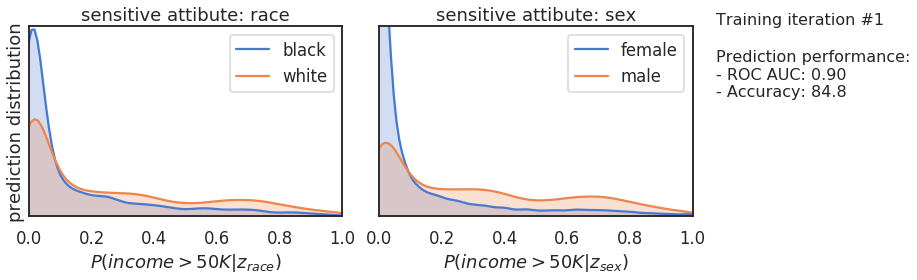

In [0]:
fig = plot_distributions(y_pre_clf, Z_test, iteration= iter, val_metrics= val_metrics, fname='biased_training.png')

## Quantitative model fairness

### p-rules
The rule states that the ratio between the probability of a positive outcome given the sensitive attribute being true and the same probability given the sensitive attribute being false is no less than p/100

![drawing](https://render.githubusercontent.com/render/math?math=%5Cmin%5Cleft%28%5Cfrac%7BP%28%5Chat%7By%7D%3D1%7Cz%3D1%29%7D%7BP%28%5Chat%7By%7D%3D1%7Cz%3D0%29%7D%2C%20%5Cfrac%7BP%28%5Chat%7By%7D%3D1%7Cz%3D0%29%7D%7BP%28%5Chat%7By%7D%3D1%7Cz%3D1%29%7D%5Cright%29%5Cgeq%5Cfrac%7Bp%7D%7B100%7D&mode=display)

In [0]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [0]:
print("The classifier satisfies the following %p-rules:")
print("\tgiven attribute race; {:.0f}%-rule".format(p_rule(y_pre_clf, Z_test['race'], threshold= 0.5)))
print("\tgiven attribute sex;  {:.0f}%-rule".format(p_rule(y_pre_clf, Z_test['sex'], threshold= 0.5)))

The classifier satisfies the following %p-rules:
	given attribute race; 42%-rule
	given attribute sex;  33%-rule


Both sensitive attributes have p%-rule significantly lower than 80%: The trained classifier is **unfair** in making its predictions

## Fair income predictions
### ADVERSARIAL TRAINING PROCEDURE
* First generative model generates actual predictions ŷ (the probability a person's income is larger than 50K) based on the input X.
* Second adversarial classifier predicts the sensitive attribute values  (race∈{black, white} and sex∈{male, female}) from the predicted ŷ of the classifier.
* Finally, the objectives that both nets try to optimize are based on the prediction losses of the target and sensitive attributes

![drawing](https://github.com/equialgo/fairness-in-ml/raw/0d4c8188633e8b149c10a78bdf141d87a0a6b42c/images/architecture.png)

### FAIRCLASSIFIER
For the classifier the objective of twofold: 
make the best possible income level predictions at the same time as ensuring that sensitive attributes cannot be derived from them. This is captured by the following objective function:

![drawing](https://render.githubusercontent.com/render/math?math=%5Cmin_%7B%5Ctheta_%7Bclf%7D%7D%5Cleft%5BLoss_%7By%7D%28%5Ctheta_%7Bclf%7D%29-%5Clambda%20Loss_%7BZ%7D%28%5Ctheta_%7Bclf%7D%2C%5Ctheta_%7Badv%7D%29%5Cright%5D.&mode=display)

Note that increasing the size of λ steers the classifier towards fairer predictions while sacrificing prediction accuracy.

In [0]:
class FairClassifier(nn.Module):
    def __init__(self, n_features, n_hidden= 32):
        super(FairClassifier, self).__init__()
        self.nn= nn.Sequential(
            nn.Linear(in_features= n_features, out_features= n_hidden),
            nn.ReLU(),
            nn.Dropout(p= 0.2),
            nn.Linear(in_features= n_hidden, out_features= n_hidden),
            nn.ReLU(),
            nn.Dropout(p= 0.2),
            nn.Linear(in_features= n_hidden, out_features= n_hidden),
            nn.ReLU(),
            nn.Dropout(p= 0.2),
            nn.Linear(in_features= n_hidden, out_features= 1)
        )
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.nn.parameters())
        
    def forward(self, x):
        return torch.sigmoid(self.nn(x))
    
    def calculate_loss(self, adv_nn, p_y, y, p_z, z, lambdas):
        return self.criterion(p_y, y) - (adv_nn.criterion(p_z, z) * lambdas).mean()
    
    def pretrain(self, data_loader):
        for x, y, _ in data_loader:
            self.zero_grad()
            p_y = self(x)
            loss = self.criterion(p_y, y)
            loss.backward()
            self.optimizer.step()
    
    def train_single_batch(self, data_loader, adv_nn, lambdas):
        for x, y, z in data_loader:
            pass
        self.zero_grad()
        p_y = self(x)
        p_z = adv_nn(p_y)#.detach()
        loss_adv = adv_nn.calculate_loss(p_z, z, lambdas)
        loss= self.calculate_loss(adv_nn, p_y, y, p_z, z, lambdas)
        loss.backward()
        self.optimizer.step()
        
    def train(self, data_loader, adv_nn, lambdas):
        for x, y, z in data_loader:
            self.zero_grad()
            p_y = self(x)
            p_z = adv_nn(p_y)#.detach()
            loss_adv = adv_nn.calculate_loss(p_z, z, lambdas)
            loss= self.calculate_loss(adv_nn, p_y, y, p_z, z, lambdas)
            loss.backward()
            self.optimizer.step()
        

### FAIR ADVERSARIAL
For the adversarial: predict race and sex based on the income level predictions of the classifier. This is captured in the following objective function: 

![drawing](https://render.githubusercontent.com/render/math?math=%5Cmin_%7B%5Ctheta_%7Badv%7D%7D%5Cleft%5BLoss_%7BZ%7D%28%5Ctheta_%7Bclf%7D%2C%5Ctheta_%7Badv%7D%29%5Cright%5D.&mode=display)

The adversarial does not care about the prediction accuracy of the classifier. It is only concerned with minimizing its own prediction losses of sensitive attributes

In [0]:
class FairAdversarial(nn.Module):
    def __init__(self, n_sensitive, n_hidden= 32):
        super(FairAdversarial, self).__init__()
        self.nn= nn.Sequential(
            nn.Linear(in_features= 1, out_features= n_hidden),
            nn.ReLU(),
            nn.Linear(in_features= n_hidden, out_features= n_hidden),
            nn.ReLU(),
            nn.Linear(in_features= n_hidden, out_features= n_hidden),
            nn.ReLU(),
            nn.Linear(in_features= n_hidden, out_features= n_sensitive)
        )
        self.criterion = nn.BCELoss(reduction= 'elementwise_mean')
        self.optimizer = optim.Adam(self.nn.parameters())
        
    def forward(self, x):
        return torch.sigmoid(self.nn(x))
    
    def calculate_loss(self, p_z, z, lambdas):
        return (self.criterion(p_z, z) * lambdas).mean()
    
    def pretrain(self, data_loader, clf_nn, lambdas):
        for x, _, z in data_loader:
            self.zero_grad()
            p_y = clf_nn(x)#.detach()
            p_z = self(p_y)
            loss = (self.criterion(p_z, z) * lambdas).mean()
            loss.backward()
            self.optimizer.step()
    
    def train_single_batch(self, data_loader, clf_nn, lambdas):
        for x, y, z in data_loader:
            pass
        self.zero_grad()
        p_y = clf_nn(x)#.detach()
        p_z = self(p_y)
        loss = self.calculate_loss(p_z, z, lambdas)
        loss.backward()
        self.optimizer.step()
    
    def train(self, data_loader, clf_nn, lambdas):
        for x, y, z in data_loader:
            self.zero_grad()
            p_y = clf_nn(x)#.detach()
            p_z = self(p_y)
            loss = self.calculate_loss(p_z, z, lambdas)
            loss.backward()
            self.optimizer.step()

In [0]:
lambdas = torch.Tensor([30, 130])
fair_clf = FairClassifier(n_features, 32)
adv = FairAdversarial(n_sensitive, 32)

In [0]:
def train_GAN(clf, adv, data_loader, lambdas):
    adv.train(data_loader, fair_clf, lambdas)
    clf.train_single_batch(data_loader, adv, lambdas)
    return clf, adv

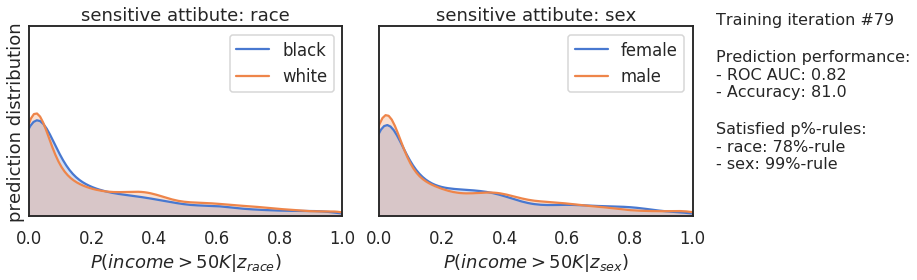

In [0]:
N_CLF_EPOCHS = 2
for epoch in range(N_CLF_EPOCHS):
    fair_clf.pretrain(train_loader)

N_ADV_EPOCHS = 5
for i in range(N_ADV_EPOCHS):
    adv.pretrain(train_loader, clf_nn= fair_clf, lambdas= lambdas)

N_EPOCH_COMBINED = 80

performance_metrics = pd.DataFrame(columns=['ROC AUC', 'Accuracy'])
fairness_metrics = {}

for epoch in range(1, N_EPOCH_COMBINED):
    fair_clf, adv = train_GAN(fair_clf, adv, train_loader, lambdas)
    with torch.no_grad():
        clf_pred = fair_clf(test_data.tensors[0])
        adv_pred = adv(clf_pred)
        
    y_post_clf = pd.Series(clf_pred.data.numpy().ravel(), index=y_test.index)
    Z_post_adv = pd.DataFrame(adv_pred.data.numpy(), columns=Z_test.columns, index= Z_test.index)
    
    performance_metrics.loc[epoch,'ROC AUC'] = roc_auc_score(y_test, y_post_clf)
    performance_metrics.loc[epoch,'Accuracy'] = 100*accuracy_score(y_test, y_post_clf > 0.5 )
    for sensitive_attr in Z_test.columns:
        fairness_metrics[sensitive_attr] = p_rule(y_post_clf, Z_test[sensitive_attr], threshold= 0.5)
    
    fig = plot_distributions(y_post_clf, Z_test, iteration= epoch, 
                             val_metrics= performance_metrics, p_rules= fairness_metrics)
    display.clear_output(wait=True)
    plt.savefig('torch_{:08d}.png'.format(epoch + 1), bbox_inches='tight')
    plt.show(plt.gcf())